In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.3 MB/s 
     |████████████████████████████████| 120 kB 71.4 MB/s 
     |████████████████████████████████| 6.6 MB 12.1 MB/s 


In [2]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 5.2 MB/s 
     |████████████████████████████████| 212 kB 57.8 MB/s 
     |████████████████████████████████| 115 kB 55.1 MB/s 
     |████████████████████████████████| 127 kB 54.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
!pip install cloud-tpu-client==0.10 torch==1.12.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.12-cp37-cp37m-linux_x86_64.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 187.4 MB 30 kB/s 
     |████████████████████████████████| 776.3 MB 15 kB/s 
     |████████████████████████████████| 57 kB 4.1 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.11
    Uninstalling google-api-python-client-1.12.11:
      Successfully uninstalled google-api-python-client-1.12.11
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.12.0 which is incompatible.
torchtext 0.13.1 requires torch==1.12.1, but you have tor

Prepare dataset

In [3]:
import pandas as pd

df = pd.read_csv("twitter_training.csv")
df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [4]:
df = df.rename(columns={"2401":"id", "Borderlands":"Product", "Positive":"Sentiment", "im getting on borderlands and i will murder you all ,": "text"})

In [5]:
df.head()

,id,Product,Sentiment,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [6]:
print(df.shape)
df.isnull().sum(axis=0)

(74681, 4)


id             0
Product        0
Sentiment      0
text         686
dtype: int64

In [7]:
df = df.dropna(axis=0)

In [8]:
set(df["Sentiment"])

{'Irrelevant', 'Negative', 'Neutral', 'Positive'}

In [9]:
df = df.drop(df[df.Sentiment=="Irrelevant"].index)
set(df["Sentiment"])

{'Negative', 'Neutral', 'Positive'}

In [10]:
labels = ['Negative', 'Neutral', 'Positive']
num_labels = len(labels)
id2label = {i: val for i, val in enumerate(labels)}
label2id = {val: i for i, val in enumerate(labels)}
df["label"] = df.Sentiment.map(lambda x: label2id[x])
df.head()

,id,Product,Sentiment,text,label
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,2
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,2
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,2
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,2
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,2


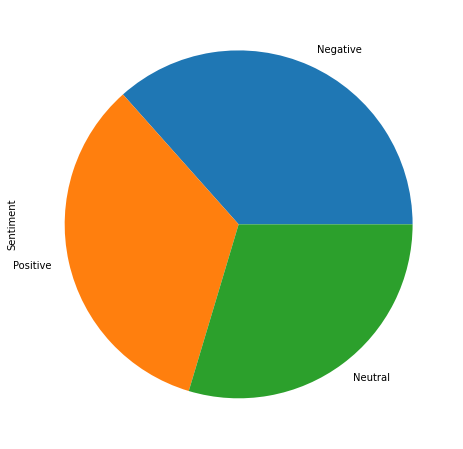

In [11]:
df.Sentiment.value_counts().plot(kind="pie", figsize=(8, 8))

In [12]:
texts = df.text.values 
texts = texts.astype(str)

In [13]:
df = df.sample(frac=0.5)

In [14]:
split_train = int(df.shape[0]*0.8)
split_test = int(df.shape[0]*0.9)
X_train = df.text[:split_train].tolist()
y_train = df.label[:split_train].tolist()
X_valid = df.text[split_train: split_test].tolist()
y_valid = df.label[split_train: split_test].tolist()
X_test = df.text[split_test:].tolist()
y_test = df.label[split_test:].tolist()

In [15]:
len(X_valid), len(y_valid)

(3056, 3056)

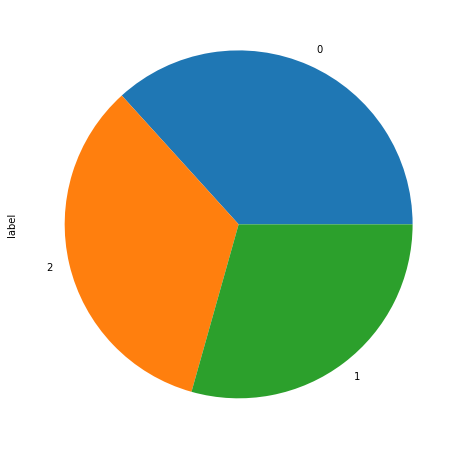

In [16]:
pd.DataFrame(y_train, columns=["label"]).label.value_counts().plot(kind="pie", figsize=(8, 8))

Train tokenizer by using WordPiece algorithm

In [17]:
from tokenizers import Tokenizer
from tokenizers.normalizers import Sequence, Lowercase, StripAccents, NFD
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.models import WordPiece
from tokenizers.processors import TemplateProcessing
from tokenizers.decoders import WordPiece as WordPieceDecoder
from tokenizers.trainers import WordPieceTrainer

In [18]:
special_tokens =  ["[CLS]", "[UNK]", "[SEP]", "[PAD]", "[MASK]"] #["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"]

temp = TemplateProcessing(single="[CLS] $0 [SEP]",
                          pair="[CLS] $A:0 [SEP]:0 $B:1 [SEP]:1",
                          special_tokens=[("[CLS]", special_tokens.index("[CLS]")), 
                                           ("[SEP]", special_tokens.index("[SEP]"))])

In [19]:
tokenizer = Tokenizer(WordPiece())

In [20]:
tokenizer.normalizer = Sequence([NFD(), Lowercase(), StripAccents()])
tokenizer.pre_tokenizer = Whitespace()
tokenizer.decoder = WordPieceDecoder()
tokenizer.post_processor = temp

In [21]:
trainer = WordPieceTrainer(vocab_size=30000, special_tokens=special_tokens)
tokenizer.train_from_iterator(texts, trainer=trainer)

In [22]:
tokenizer.enable_truncation(max_length=512)
tokenizer.enable_padding()

In [23]:
tokenizer.encode("This game isfascinating").tokens

['[CLS]', 'this', 'game', 'is', '##fa', '##sc', '##inating', '[SEP]']

In [24]:
tokenizer.save("TwitterTokenizer.json")

BERT model

In [25]:
import torch
from transformers import BertModel, BertConfig
from torch.utils.data import Dataset
from torch.optim import AdamW
from datasets import load_metric
from tqdm.auto import tqdm

In [26]:
metric = load_metric("accuracy")

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [29]:
tokenizer = Tokenizer.from_file("TwitterTokenizer.json")

In [30]:
class DatasetLoader(Dataset):
    def __init__(self, encoded, labels):
        self.encoded = encoded
        self.labels = labels

    def __getitem__(self, idx):
        item = {}
        item["input_ids"] = torch.tensor(self.encoded[idx].ids)
        item["attention_mask"] = torch.tensor(self.encoded[idx].attention_mask)
        item["label"] = torch.tensor(self.labels[idx])
        return item 

    def __len__(self):
        return len(self.encoded)


In [31]:
train_dataset = DatasetLoader(tokenizer.encode_batch(X_train), y_train)
valid_dataset = DatasetLoader(tokenizer.encode_batch(X_valid), y_valid)
test_dataset = DatasetLoader(tokenizer.encode_batch(X_test), y_test)

In [39]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, num_workers=2, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, num_workers=2, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, num_workers=2, batch_size=32, shuffle=False)

In [33]:
config = BertConfig(hidden_size=128,
                    num_attention_heads=2,
                    intermediate_size=2048)
config

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [45]:
class TwitterBert(torch.nn.Module):
    def __init__(self, device: str):
        super().__init__()
        self.BertLayer = BertModel(config).to(device)

        """for para in self.BertLayer.parameters():
            para.requires_grad = False"""

        self.OutputLayer = torch.nn.Linear(128, num_labels, device=device)
    
    def forward(self, input_ids, attention_mask):
        sequence_output, pooled_output = self.BertLayer(input_ids, attention_mask=attention_mask).values()
        output = self.OutputLayer(pooled_output) #sequence_output[:, 0, :]
        output = torch.nn.Softmax(dim=-1)(output)
        return output

In [46]:
loss_function = torch.nn.CrossEntropyLoss()

In [47]:
def optimize(model, train_loader, valid_loader, epochs=1,):
    progress_bar_train = tqdm(range(epochs*len(train_loader)))
    progress_bar_valid = tqdm(range(epochs*len(valid_loader)))
    optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            output = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_function(output, labels)
            loss.backward()
            optimizer.step()
            progress_bar_train.update(1)
        model.eval()
        for batch in valid_loader: 
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            with torch.no_grad():
              output = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(output, dim=-1)
            metric.add_batch(predictions=predictions, references=labels)
            progress_bar_valid.update(1)
        print(f"epoch {epoch}: {metric.compute()}")

In [48]:
model = TwitterBert(device)

In [ ]:
optimize(model, train_loader, valid_loader, epochs=5)

  0%|          | 0/15280 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

epoch 0: {'accuracy': 0.5026178010471204}
epoch 1: {'accuracy': 0.6465968586387435}
epoch 2: {'accuracy': 0.6920811518324608}
epoch 3: {'accuracy': 0.7081151832460733}


twitter-roberta-base-sentiment-latest





In [ ]:
# imports the torch_xla package
import torch_xla
import torch_xla.core.xla_model as xm

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import DataLoader
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import Dataset

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = xm.xla_device()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest", num_labels=3, id2label=id2label, label2id=label2id).to(device)

In [ ]:
class DatasetLoader(Dataset):
    def __init__(self, encoded, labels):
        self.encoded = encoded
        self.labels = labels

    def __getitem__(self, idx):
        item = {}
        item["input_ids"] = torch.tensor(self.encoded[idx].ids)
        item["attention_mask"] = torch.tensor(self.encoded[idx].attention_mask)
        item["labels"] = torch.tensor(self.labels[idx])
        return item 

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = DatasetLoader(tokenizer(X_train, truncation=True, padding=True, max_length=512), y_train)
valid_dataset = DatasetLoader(tokenizer(X_valid, truncation=True, padding=True, max_length=512), y_valid)
test_dataset = DatasetLoader(tokenizer(X_test, truncation=True, padding=True, max_length=512), y_test)

In [ ]:
def compute_metric(preds):
    labels = preds.label_ids
    preds = preds.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    acc = accuracy_score(preds, labels)
    return {
        "Accuracy":acc,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    }

In [ ]:
train_args = TrainingArguments(output_dir="TwitterBert",
                               do_train=True,
                               do_eval=True,
                               num_train_epochs=3,
                               per_device_train_batch_size=8,
                               per_device_eval_batch_size=32,
                               weight_decay=0.01,
                               logging_strategy="steps",
                               logging_dir="./logs",
                               evaluation_strategy="steps",
                               warmup_steps=100,
                               eval_steps=500,
                               save_steps = 5000,
                               fp16= torch.cuda.is_available(),
                               tpu_num_cores=16,
                               load_best_model_at_end=True)

In [ ]:
train = Trainer(model = model,
                args=train_args,
                train_dataset = train_dataset,
                eval_dataset = valid_dataset,
                compute_metrics=compute_metric)

In [ ]:
train.train()

In [ ]:
q =[ train.evaluate(eval_dataset=data) for data in [train_dataset, valid_dataset, test_dataset]]
pd.DataFrame(q,index=["Train", "Valid", "Test"])

In [ ]:
num = 0
for i, text in enumerate(X_train):
    encoding = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)
    outputs = model(input_ids, attention_mask=attention_mask)
    outputs = outputs.logits.argmax(-1)
    num += 1 if outputs.item() == y_train[i] else 0 
    """if outputs.item() != y_train[i]:
        print(i, outputs.item(), y_train[i], text)
        break"""
    print(num, i+1, num/(i+1))

In [ ]:
model.config